### Investigate the relationship between option order book update frequencies and the future prices update frequencies
* data processing
    * find the ATM call and put, most updated call and most updated put
    * for each single instrument in a day
    * filter out snapshot
    * remove duplicated timepoint
    * round to nearest minutes
    * groupby timestamp and count -> update frequency/min

In [205]:
from croqr.common.config import LOCAL_DATA_DIR
import os
import pandas as pd
from datetime import datetime, timedelta
import croqr.data.deribit.data_utils as datautils
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time
from croqr.common.utils import print_time_from_t0
from croqr.common.dt_utils import DataTimeUtils
from importlib import reload
import matplotlib.pyplot as plt

In [206]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import qgrid
gr=qgrid.show_grid
pd.core.frame.DataFrame.gr=gr

In [ ]:
! jupyter labextension install jupyterlab-plotly
# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

In [38]:
reload(datautils)

<module 'croqr.data.deribit.data_utils' from 'c:\\users\\wang\\documents\\github\\croqr\\croqr\\data\\deribit\\data_utils.py'>

In [6]:
TARDIS_DATA_PATH = os.path.join(LOCAL_DATA_DIR, 'tardis') 

### load and process options data

#### incremental_book_L2

In [8]:
symbol = 'OPTIONS'
date = "2021-10-01"
data_type = "incremental_book_L2" #"quotes"

t0 = time.time()
fname = 'deribit_{}_{}_{}.csv.gz'.format(data_type, date, symbol)
df = pd.read_csv(os.path.join(TARDIS_DATA_PATH, fname))
print_time_from_t0(t0)

In [63]:
df.head()

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount
0,deribit,BTC-31DEC21-36000-P,1633046400043000,1633046400045532,False,ask,0.0860,35.8
1,deribit,BTC-31DEC21-36000-P,1633046400043000,1633046400045532,False,ask,0.0855,12.6
2,deribit,BTC-31DEC21-36000-P,1633046400047000,1633046400055104,False,ask,0.0860,26.8
3,deribit,BTC-31DEC21-36000-P,1633046400047000,1633046400055104,False,ask,0.0855,21.6
4,deribit,BTC-31DEC21-36000-P,1633046400048000,1633046400055148,False,ask,0.0860,24.7


In [64]:
df1 = df.query('is_snapshot==False')[['symbol','timestamp', 'side','price','amount']]

In [65]:
df1.head()

,symbol,timestamp,side,price,amount
0,BTC-31DEC21-36000-P,1633046400043000,ask,0.0860,35.8
1,BTC-31DEC21-36000-P,1633046400043000,ask,0.0855,12.6
2,BTC-31DEC21-36000-P,1633046400047000,ask,0.0860,26.8
3,BTC-31DEC21-36000-P,1633046400047000,ask,0.0855,21.6
4,BTC-31DEC21-36000-P,1633046400048000,ask,0.0860,24.7


In [66]:
df2 = df1.pipe(datautils.DeribitUtils.parse_symbol_col).pipe(datautils.DeribitUtils.parse_time_col).query('t2m<=168 and t2m>0')

'parse_symbol_col'  30.52 sec
'parse_time_col'  8.59 sec


In [67]:
df2_btc_c = df2.query('instrument=="BTC" and type=="C"')

In [68]:
df2_btc_c.head()

,symbol,timestamp,side,price,amount,instrument,expire,strike,type,timestamp_dt,t2m
20,BTC-2OCT21-44000-C,1633046400134000,bid,0.0125,0.0,BTC,2021-10-02 08:00:00,44000.0,C,2021-10-01 00:00:00.134,32.0
70,BTC-2OCT21-44000-C,1633046400236000,bid,0.0125,18.0,BTC,2021-10-02 08:00:00,44000.0,C,2021-10-01 00:00:00.236,32.0
7584,BTC-1OCT21-45000-C,1633046400560000,bid,0.0010,2.6,BTC,2021-10-01 08:00:00,45000.0,C,2021-10-01 00:00:00.560,8.0
7684,BTC-1OCT21-44000-C,1633046402272000,bid,0.0045,25.4,BTC,2021-10-01 08:00:00,44000.0,C,2021-10-01 00:00:02.272,8.0
7685,BTC-1OCT21-44000-C,1633046402272000,bid,0.0055,20.1,BTC,2021-10-01 08:00:00,44000.0,C,2021-10-01 00:00:02.272,8.0


In [109]:
df2_btc_c_heat = df2_btc_c.groupby(['strike','t2m'])['timestamp_dt'].nunique().unstack()

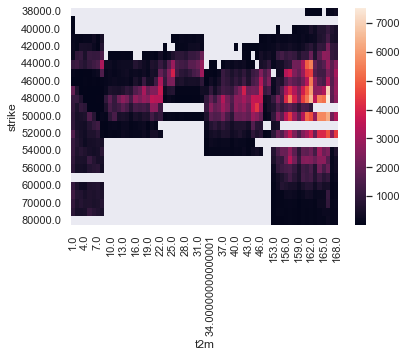

In [203]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(df2_btc_c_heat)

In [57]:
df.query('symbol=="BTC-01CT21-70000-C"')

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount


In [79]:
df2_btc_c.query('strike==70000').query('type=="C"').query('t2m==1')['price'].unique()

array([0.0005, 0.001 ])

<AxesSubplot:xlabel='timestamp_dt'>

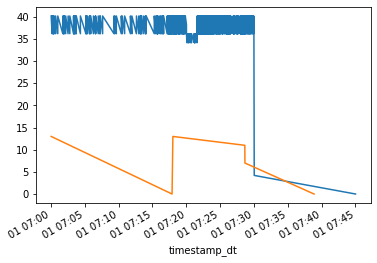

In [80]:
df2_btc_c.query('strike==70000').query('type=="C"').query('t2m==1').query('price==0.0005').groupby('timestamp_dt')['amount'].max().plot()
df2_btc_c.query('strike==70000').query('type=="C"').query('t2m==1').query('price==0.001').groupby('timestamp_dt')['amount'].max().plot()

<AxesSubplot:xlabel='timestamp_dt'>

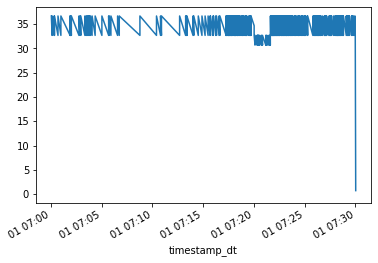

In [82]:
df2_btc_c.query('strike==50000').query('type=="C"').query('t2m==1').query('price==0.0005').groupby('timestamp_dt')['amount'].max().plot()
df2_btc_c.query('strike==50000').query('type=="C"').query('t2m==1').query('price==0.001').groupby('timestamp_dt')['amount'].max().plot()

In [104]:
df2_btc_c.query('strike==50000').query('type=="C"').query('t2m==1')

,symbol,timestamp,side,price,amount,instrument,expire,strike,type,timestamp_dt,t2m
3989235,BTC-1OCT21-50000-C,1633071602968000,ask,0.0005,36.7,BTC,2021-10-01 08:00:00,50000.0,C,2021-10-01 07:00:02.968,1.0
3989237,BTC-1OCT21-50000-C,1633071602970000,ask,0.0010,0.0,BTC,2021-10-01 08:00:00,50000.0,C,2021-10-01 07:00:02.970,1.0
3989801,BTC-1OCT21-50000-C,1633071607522000,ask,0.0005,32.7,BTC,2021-10-01 08:00:00,50000.0,C,2021-10-01 07:00:07.522,1.0
3989856,BTC-1OCT21-50000-C,1633071607539000,ask,0.0005,36.7,BTC,2021-10-01 08:00:00,50000.0,C,2021-10-01 07:00:07.539,1.0
3993626,BTC-1OCT21-50000-C,1633071620345000,ask,0.0005,32.7,BTC,2021-10-01 08:00:00,50000.0,C,2021-10-01 07:00:20.345,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4748951,BTC-1OCT21-50000-C,1633073398318000,ask,0.0005,32.7,BTC,2021-10-01 08:00:00,50000.0,C,2021-10-01 07:29:58.318,1.0
4749133,BTC-1OCT21-50000-C,1633073398429000,ask,0.0005,36.7,BTC,2021-10-01 08:00:00,50000.0,C,2021-10-01 07:29:58.429,1.0
4750092,BTC-1OCT21-50000-C,1633073400011000,ask,0.0005,32.7,BTC,2021-10-01 08:00:00,50000.0,C,2021-10-01 07:30:00.011,1.0
4753337,BTC-1OCT21-50000-C,1633073402723000,ask,0.0005,0.7,BTC,2021-10-01 08:00:00,50000.0,C,2021-10-01 07:30:02.723,1.0


strike= 38000.0
ask prices []


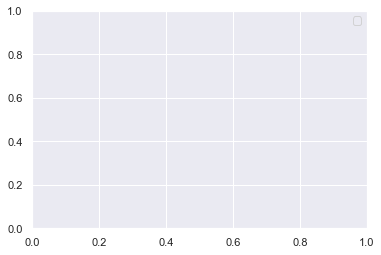

strike= 39000.0
ask prices [0.131, 0.1745]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

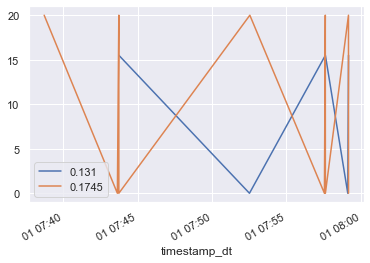

strike= 40000.0
ask prices [0.1085, 0.109, 0.6895]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

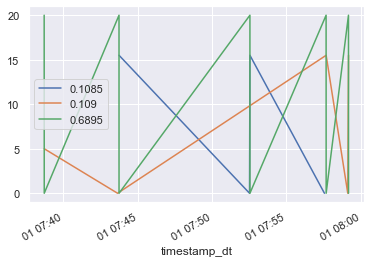

strike= 41000.0
ask prices [0.0565, 0.057, 0.0575, 0.058, 0.0585, 0.059, 0.0595, 0.06, 0.0605, 0.061, 0.0615, 0.062, 0.0625, 0.063, 0.0635, 0.064, 0.0645, 0.065, 0.0655, 0.066, 0.0665, 0.067, 0.0675, 0.068, 0.0685, 0.069, 0.0695, 0.07, 0.0705, 0.071, 0.0715, 0.072, 0.0725, 0.073, 0.0735, 0.074, 0.0745, 0.075, 0.0755, 0.076, 0.0765, 0.0775, 0.078, 0.0785, 0.079, 0.0795, 0.08, 0.0805, 0.0815, 0.082, 0.0825, 0.083, 0.0835, 0.084, 0.085, 0.0855, 0.086, 0.0865, 0.087, 0.0875, 0.088, 0.0905, 0.091, 0.0915, 0.092, 0.0925, 0.093, 0.0945, 0.095]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

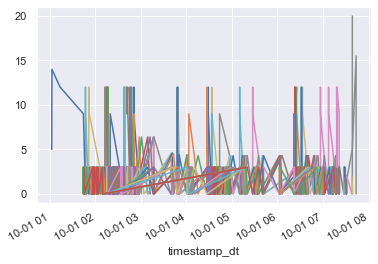

strike= 42000.0
ask prices [0.0335, 0.034, 0.0345, 0.035, 0.0355, 0.036, 0.0365, 0.037, 0.0375, 0.038, 0.0385, 0.039, 0.0395, 0.04, 0.0405, 0.041, 0.0415, 0.042, 0.0425, 0.043, 0.0435, 0.044, 0.0445, 0.045, 0.0455, 0.046, 0.0465, 0.047, 0.0475, 0.048, 0.0485, 0.049, 0.0495, 0.05, 0.0505, 0.051, 0.0515, 0.052, 0.0525, 0.053, 0.0535, 0.054, 0.055, 0.0555, 0.056, 0.0565, 0.057, 0.0575, 0.058, 0.0585, 0.059, 0.0595, 0.06, 0.0605, 0.061, 0.0615, 0.062, 0.0625, 0.063, 0.0635, 0.064, 0.0645, 0.065, 0.0655, 0.066, 0.0685, 0.069, 0.0695, 0.07, 0.0705, 0.072, 0.0725, 0.073]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

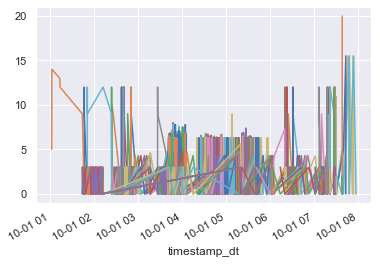

strike= 43000.0
ask prices [0.0115, 0.012, 0.0125, 0.013, 0.0135, 0.014, 0.0145, 0.015, 0.0155, 0.016, 0.0165, 0.017, 0.0175, 0.018, 0.0185, 0.019, 0.0195, 0.02, 0.0205, 0.021, 0.0215, 0.022, 0.0225, 0.023, 0.0235, 0.024, 0.0245, 0.025, 0.0255, 0.026, 0.0265, 0.027, 0.0275, 0.028, 0.0285, 0.029, 0.0295, 0.03, 0.0305, 0.031, 0.0315, 0.0325, 0.033, 0.0335, 0.034, 0.0345, 0.035, 0.0355, 0.036, 0.0365, 0.037, 0.0375, 0.038, 0.0385, 0.039, 0.0395, 0.0405, 0.041, 0.0415, 0.042, 0.0425, 0.043, 0.0435, 0.046, 0.0465, 0.047, 0.0475, 0.048, 0.0485, 0.0505, 0.051]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

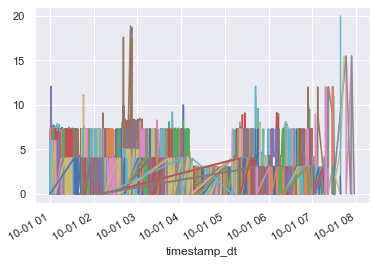

strike= 44000.0
ask prices [0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.009, 0.0095, 0.01, 0.0105, 0.011, 0.0115, 0.012, 0.0125, 0.013, 0.0135, 0.014, 0.0145, 0.015, 0.0155, 0.016, 0.0165, 0.017, 0.0175, 0.018, 0.0185, 0.019, 0.0195, 0.02, 0.0205, 0.021, 0.0235, 0.024, 0.0245, 0.025, 0.0255, 0.026, 0.0265, 0.027, 0.0285, 0.029, 0.15, 0.1545, 0.155]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

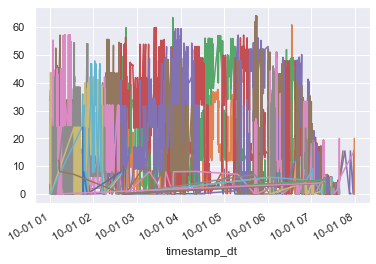

strike= 45000.0
ask prices [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.006, 0.04]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

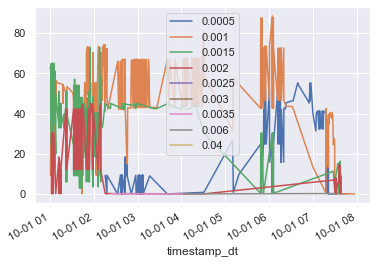

strike= 46000.0
ask prices [0.0005, 0.001, 0.0015, 0.002]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

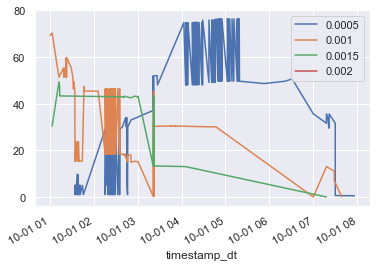

strike= 47000.0
ask prices [0.0005, 0.001, 0.002]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

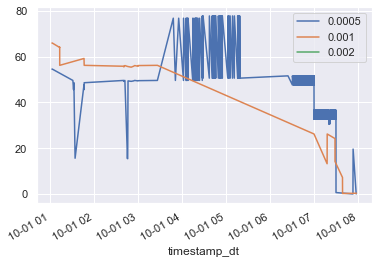

strike= 48000.0
ask prices [0.0005, 0.001, 0.023, 0.0235]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

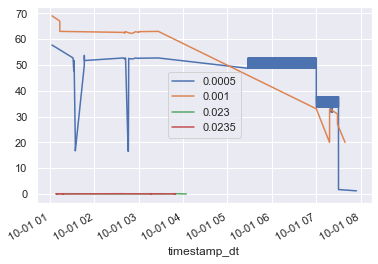

strike= 49000.0
ask prices [0.0005, 0.001, 0.0045]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

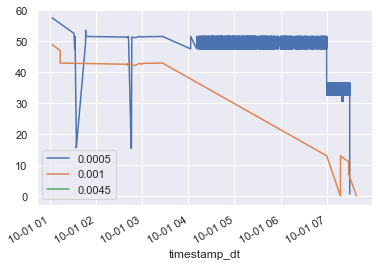

strike= 50000.0
ask prices [0.0005, 0.001, 0.008]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

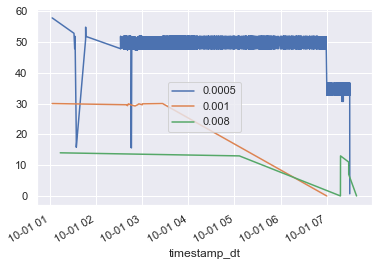

strike= 51000.0
ask prices [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

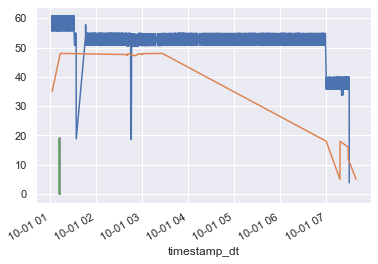

strike= 52000.0
ask prices [0.0005, 0.001, 0.004, 0.008]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

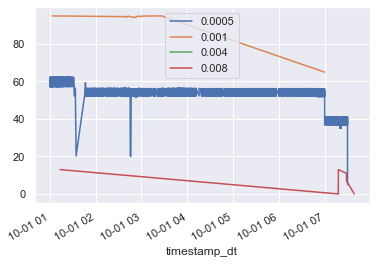

strike= 53000.0
ask prices [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

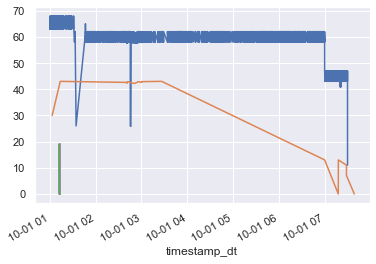

strike= 54000.0
ask prices [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

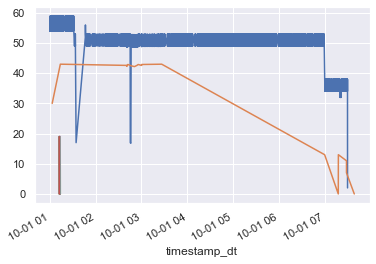

strike= 55000.0
ask prices [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

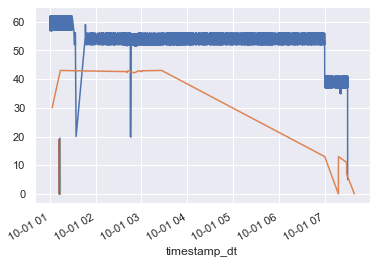

strike= 56000.0
ask prices [0.0005, 0.001, 0.0015, 0.002, 0.008]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

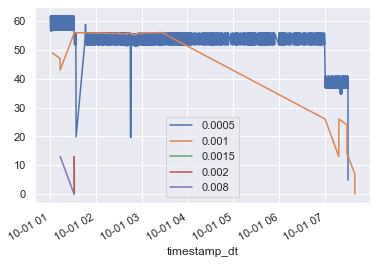

strike= 58000.0
ask prices []


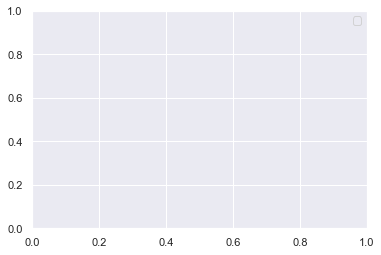

strike= 60000.0
ask prices [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

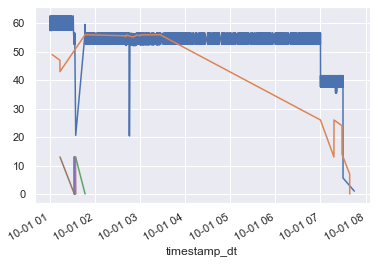

strike= 65000.0
ask prices [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

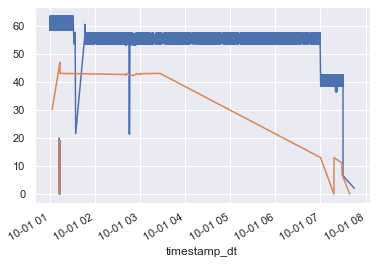

strike= 70000.0
ask prices [0.0005, 0.001, 0.0015, 0.002]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

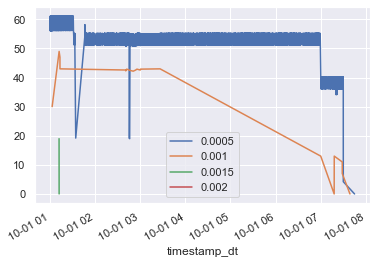

strike= 75000.0
ask prices [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075]


<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

<AxesSubplot:xlabel='timestamp_dt'>

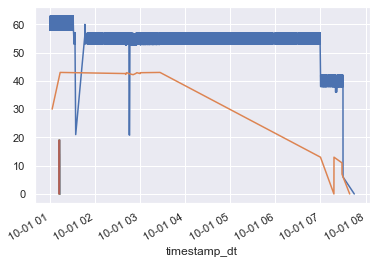

strike= 80000.0
ask prices []


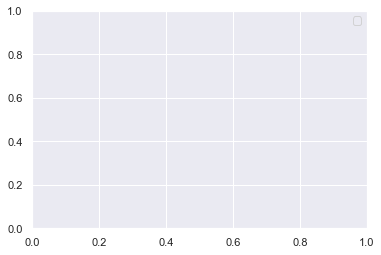

In [200]:
for strike in sorted(list(df2_btc_c['strike'].unique())):
    #strike=44000
    print('strike=', strike)
    df2plot = df2_btc_c.query('strike==@strike').query('type=="C"').query('side=="ask"').query('t2m<8')
    prices = sorted(list(df2plot['price'].unique()))
    print('ask prices', prices)
    for price in prices:
        df2plot.query('price==@price').groupby('timestamp_dt')['amount'].max().plot()
    if len(prices)<13:
        plt.legend(prices)
    plt.show()

<AxesSubplot:xlabel='timestamp_dt'>

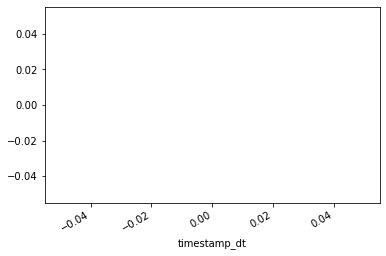

In [77]:
df2_btc_c.query('strike==70000').query('type=="C"').query('t2m==1').query('price==0.0020').groupby('timestamp_dt')['amount'].max().plot()

In [94]:
list(df2_btc_c['strike'].unique())[0]

44000.0

### check quote data

In [ ]:
symbol = 'OPTIONS'
date = "2021-10-01"
data_type = "quotes" #"quotes"

t0 = time.time()
fname = 'deribit_{}_{}_{}.csv.gz'.format(data_type, date, symbol)
df = pd.read_csv(os.path.join(TARDIS_DATA_PATH, fname))
print_time_from_t0(t0)

df1 = df.pipe(datautils.DeribitUtils.parse_symbol_col).pipe(datautils.DeribitUtils.parse_time_col).query('t2m<=168 and t2m>0')

df1_btc_c = df1.query('instrument=="BTC" and type=="C"')

df1_btc_c.set_index(['strike','expire'])

def attach_col(df):
    df = df.sort_values('timestamp_dt')
    df['update'] = (df['ask_price'].diff()!=0) | (df['bid_price'].diff()!=0)
    return df['update'].sum()

df1_btc_c

df1_btc_c.groupby(['strike','expire','t2m']).apply(attach_col).reset_index().groupby(['strike','t2m'])[0].max().unstack()/60

ax = sns.heatmap(_)

### 19 May option quote

In [208]:
symbol = 'OPTIONS'
date = "2021-05-19"
data_type = "quotes" #"quotes"

t0 = time.time()
fname = 'deribit_{}_{}_{}.csv.gz'.format(data_type, date, symbol)
df = pd.read_csv(os.path.join(TARDIS_DATA_PATH, fname))
print_time_from_t0(t0)

df1 = df.pipe(datautils.DeribitUtils.parse_symbol_col).pipe(datautils.DeribitUtils.parse_time_col).query('t2m<=168 and t2m>0')

18.12 sec
'parse_symbol_col'  26.78 sec
'parse_time_col'  4.37 sec


In [212]:
df1

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,instrument,expire,strike,type,timestamp_dt,t2m
114,deribit,BTC-21MAY21-90000-C,1621382398078000,1621382400293001,4.7,0.0005,NaN,NaN,BTC,2021-05-21 08:00:00,90000.0,C,2021-05-18 23:59:58.078,57.0
115,deribit,BTC-21MAY21-68000-C,1621382398081000,1621382400294479,3.0,0.0005,NaN,NaN,BTC,2021-05-21 08:00:00,68000.0,C,2021-05-18 23:59:58.081,57.0
116,deribit,BTC-21MAY21-60000-C,1621382396064000,1621382400294493,0.6,0.0005,NaN,NaN,BTC,2021-05-21 08:00:00,60000.0,C,2021-05-18 23:59:56.064,57.0
117,deribit,BTC-21MAY21-58000-C,1621382399085000,1621382400294515,90.6,0.0010,NaN,NaN,BTC,2021-05-21 08:00:00,58000.0,C,2021-05-18 23:59:59.085,57.0
118,deribit,BTC-21MAY21-57000-P,1621382399088000,1621382400294532,NaN,NaN,0.2400,0.1,BTC,2021-05-21 08:00:00,57000.0,P,2021-05-18 23:59:59.088,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21167479,deribit,BTC-21MAY21-37000-P,1621468799924000,1621468799939615,6.5,0.0485,0.0450,4.5,BTC,2021-05-21 08:00:00,37000.0,P,2021-05-19 23:59:59.924,33.0
21167480,deribit,BTC-20MAY21-37000-C,1621468799922000,1621468799939615,0.7,0.0215,0.0195,3.6,BTC,2021-05-20 08:00:00,37000.0,C,2021-05-19 23:59:59.922,9.0
21167481,deribit,BTC-21MAY21-42000-C,1621468799927000,1621468799949181,4.0,0.0060,0.0045,1.4,BTC,2021-05-21 08:00:00,42000.0,C,2021-05-19 23:59:59.927,33.0
21167482,deribit,ETH-20MAY21-2350-P,1621468799931000,1621468799952114,10.0,0.0240,0.0205,16.0,ETH,2021-05-20 08:00:00,2350.0,P,2021-05-19 23:59:59.931,9.0


In [213]:
df1_btc_c = df1.query('instrument=="BTC" and type=="C"')
display(df1_btc_c.shape)

(1248384, 14)

In [214]:

instrument='BTC'
type_ = 'C'
print(instrument,type_)
df1_int_type = df1.query('instrument==@instrument and type==@type_')
df1_int_type_heat = df1_int_type.groupby(['strike','expire','t2m']).apply(attach_col).reset_index().groupby(['strike','t2m'])[0].max().unstack()/60

BTC C


In [ ]:
df1_int_type_heat

Text(0.5, 1.0, 'BTC C 2021-05-19')

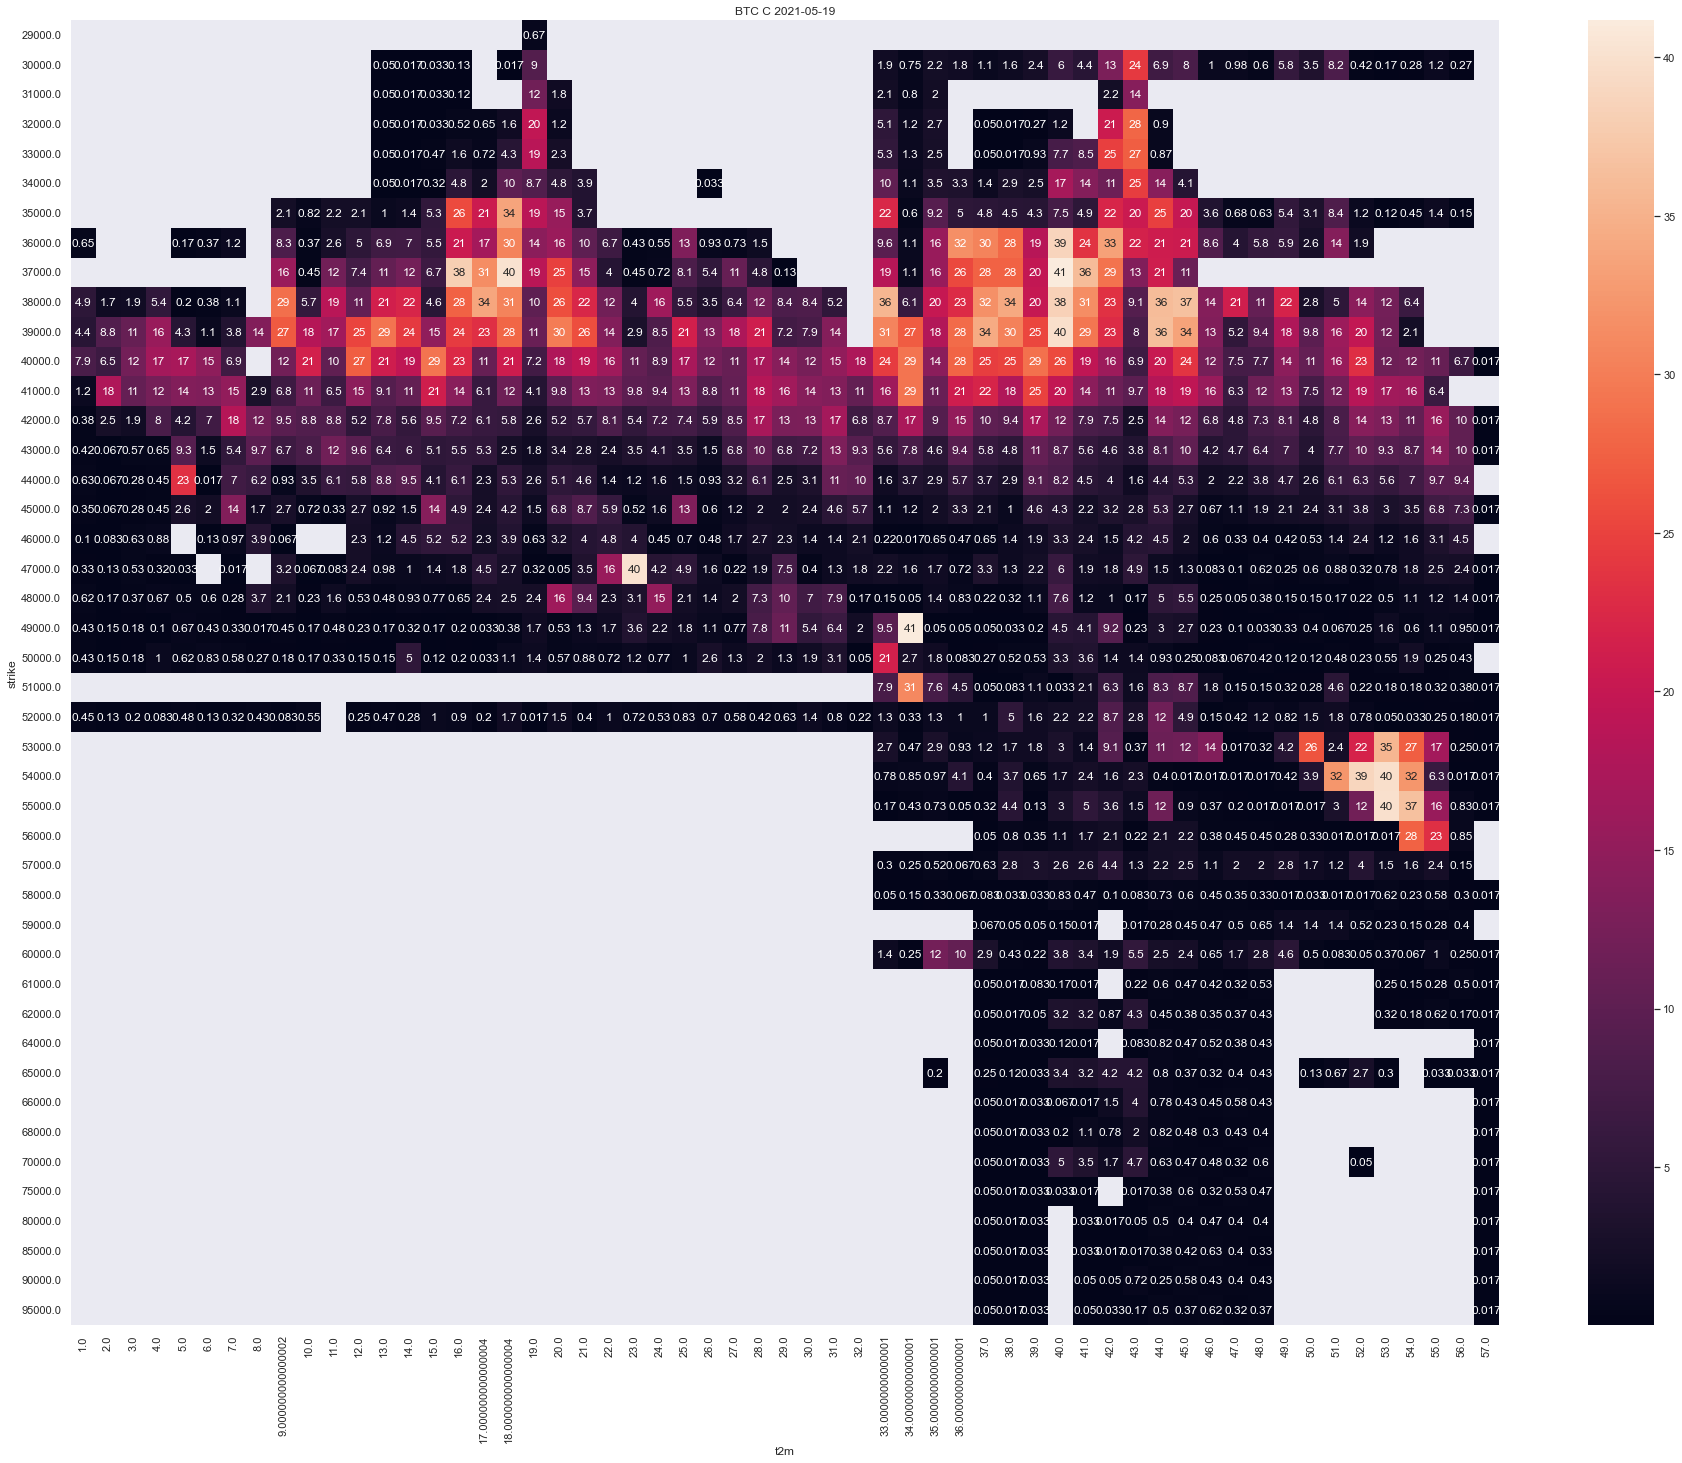

In [217]:
fig = plt.figure(figsize=(32,24))
ax = sns.heatmap(df1_int_type_heat, annot=True)
plt.title('{} {} {}'.format(instrument, type_, date))
figure = ax.get_figure()    
plt.show()

BTC C


Text(0.5, 1.0, 'BTC C 2021-05-19')

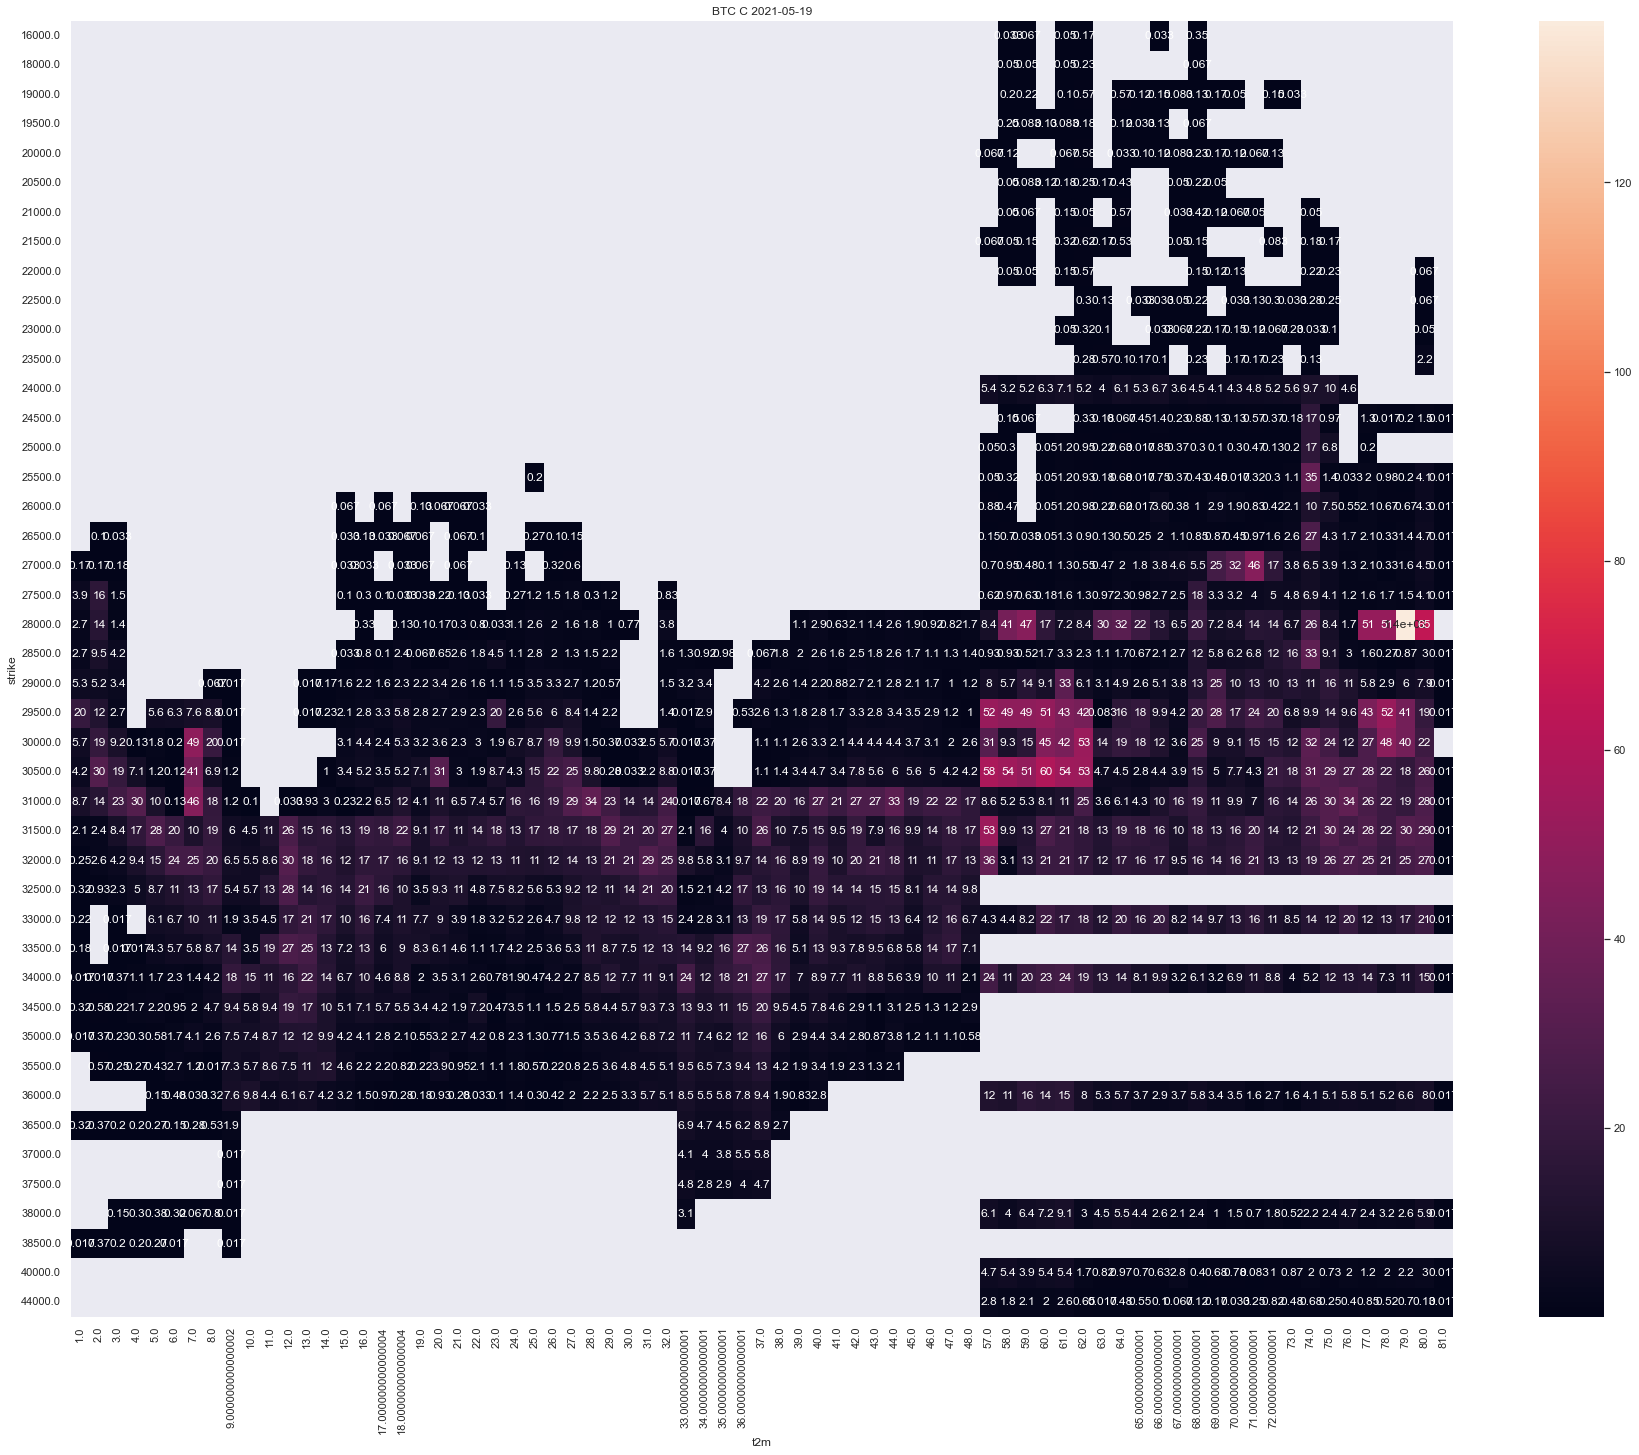

BTC P


Text(0.5, 1.0, 'BTC P 2021-05-19')

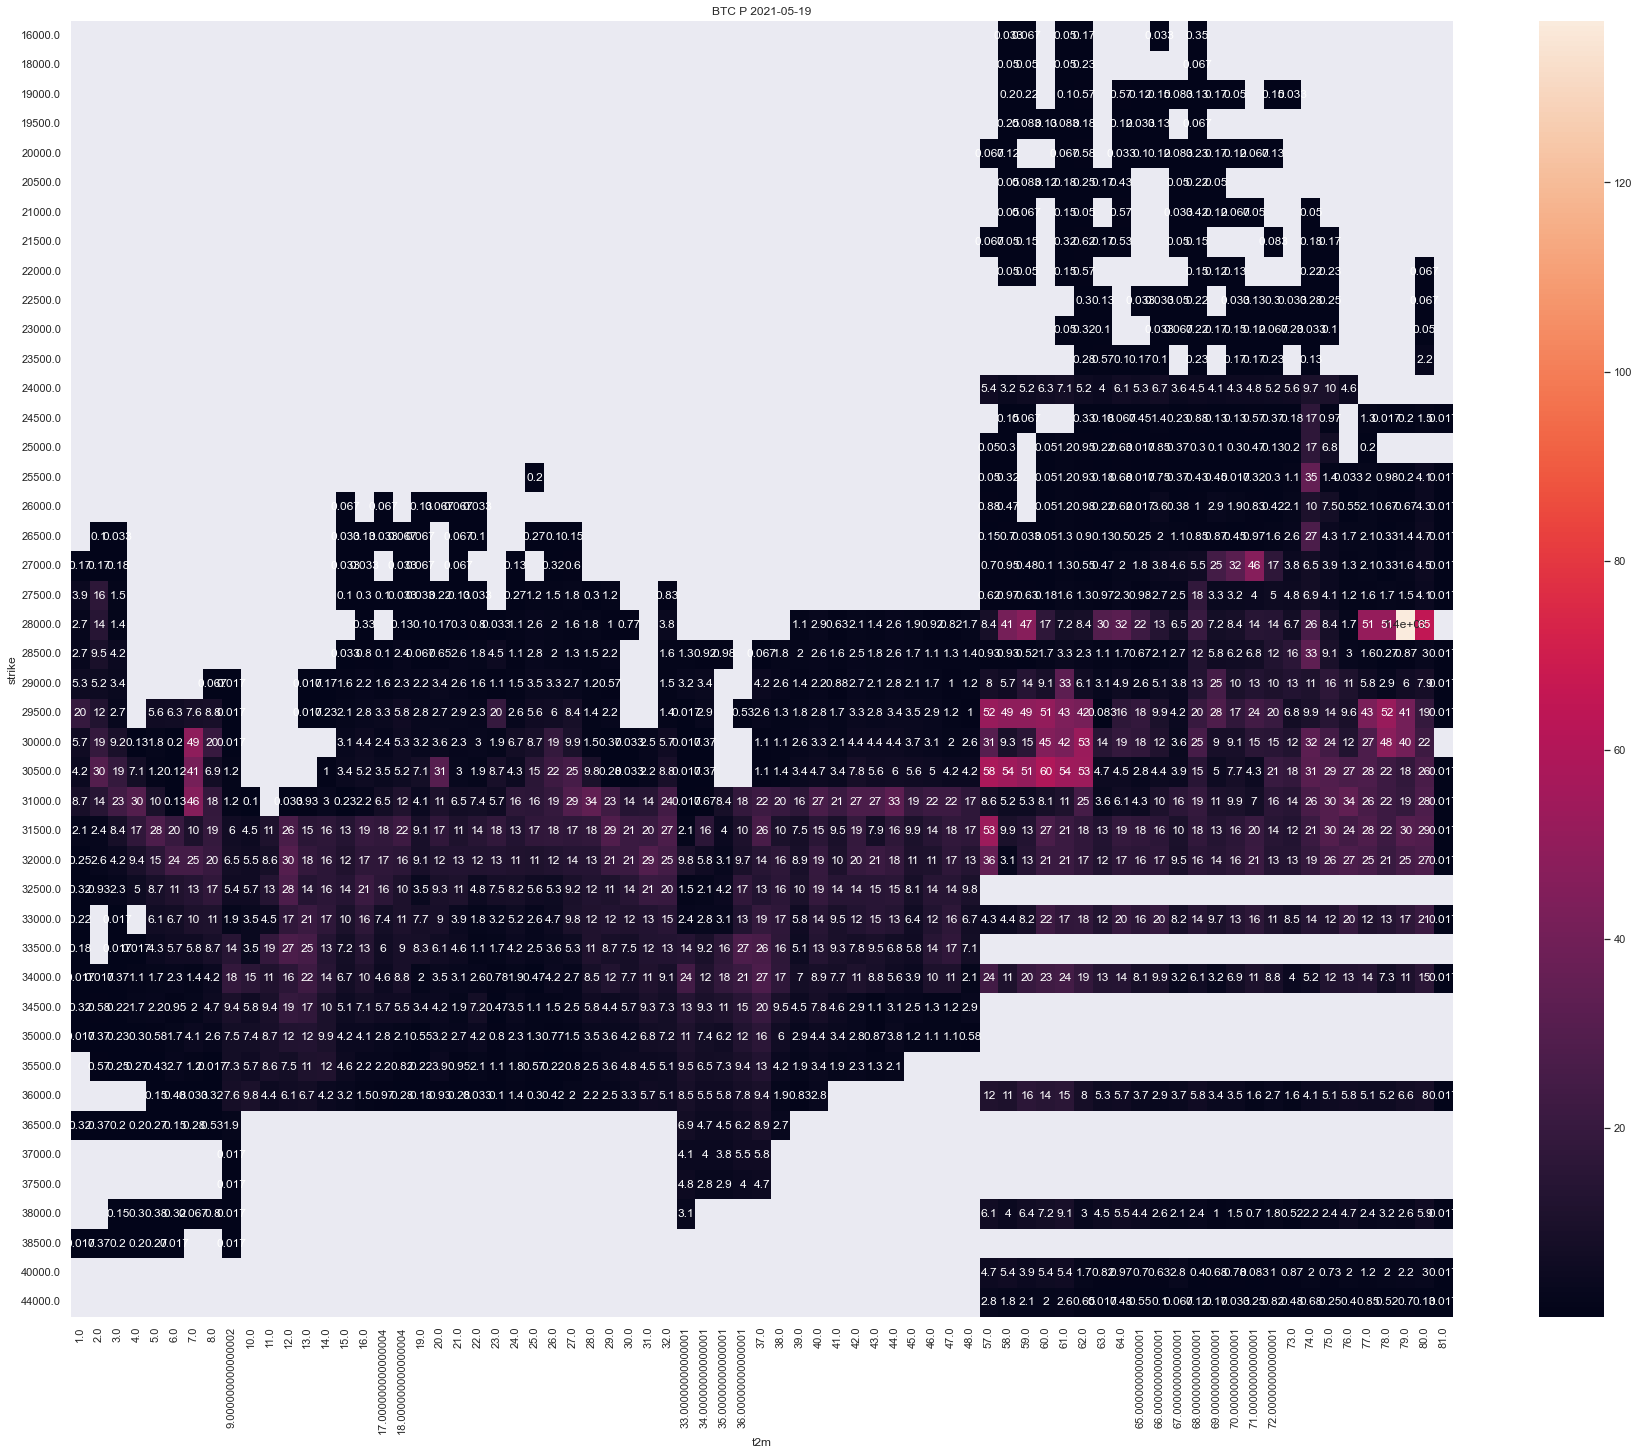

ETH C


Text(0.5, 1.0, 'ETH C 2021-05-19')

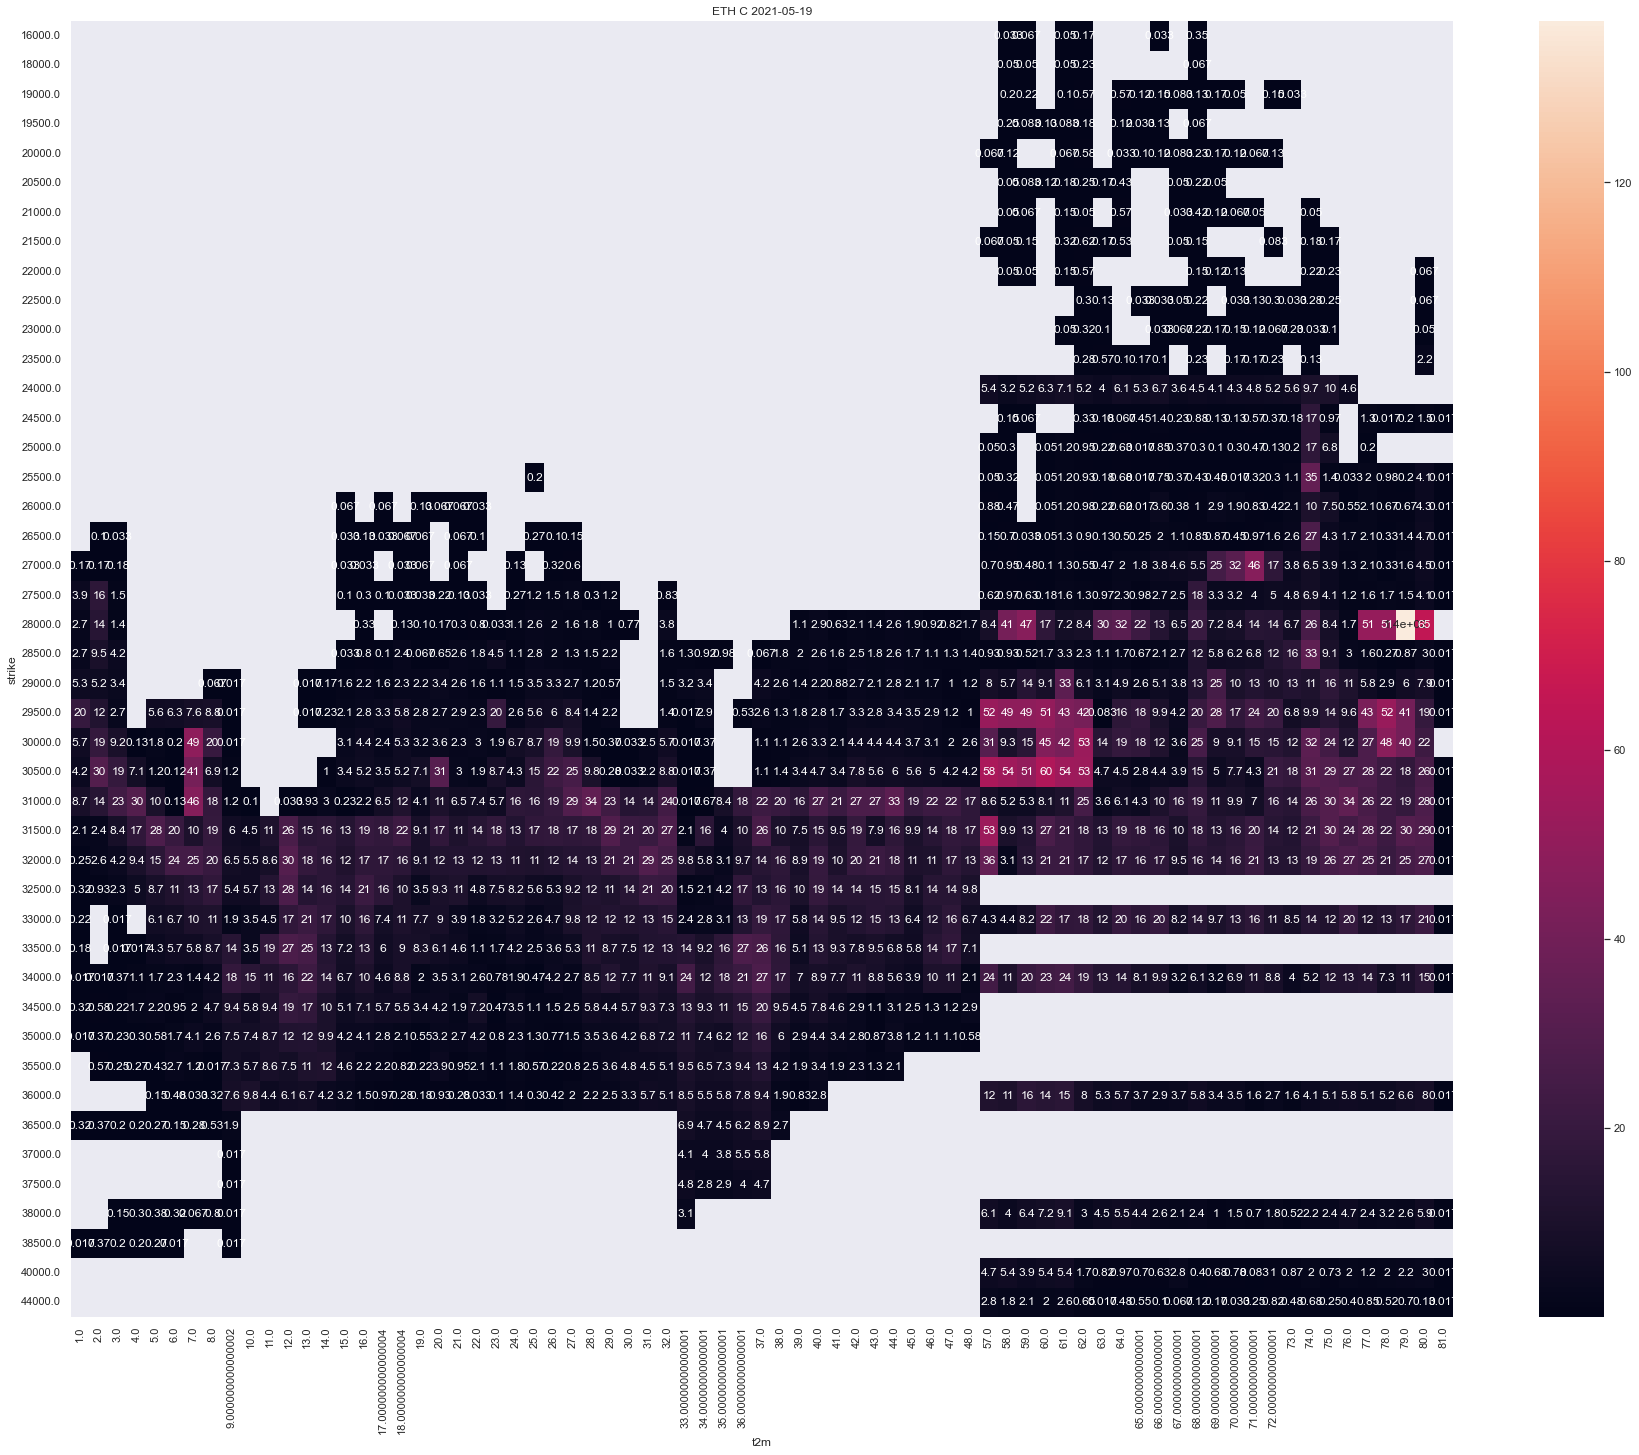

ETH P


Text(0.5, 1.0, 'ETH P 2021-05-19')

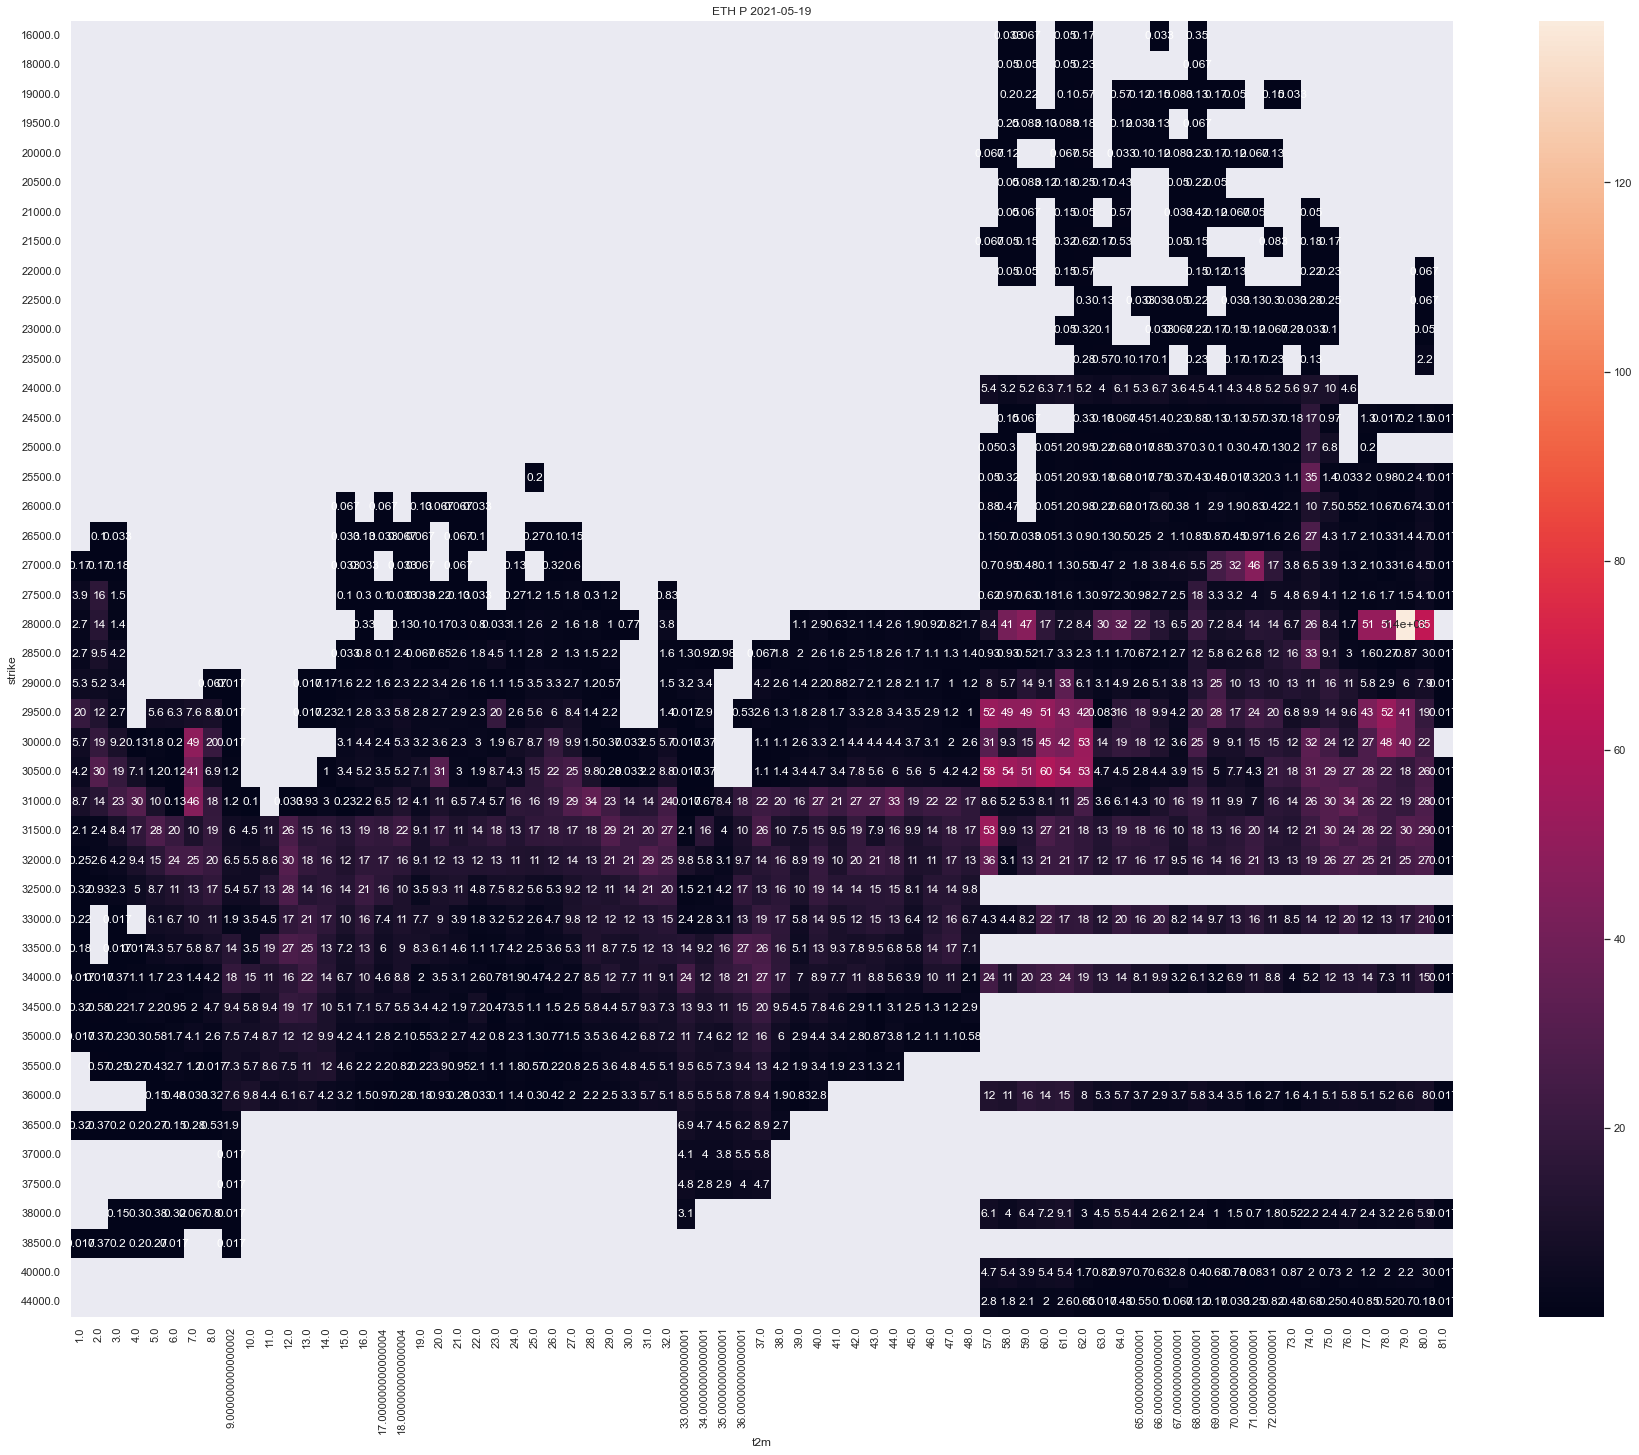

In [165]:
for instrument in ['BTC','ETH']:
    for type_ in ['C','P']:
        print(instrument,type_)
        df1_int_type = df1.query('instrument==@instrument and type==@type_')
        df1_int_type_heat = df1_int_type.groupby(['strike','expire','t2m']).apply(attach_col).reset_index().groupby(['strike','t2m'])[0].max().unstack()/60
        fig = plt.figure(figsize=(32,24))
        ax = fig.add_axes([0.1,0.1,0.75,0.75])
        ax = sns.heatmap(df1_btc_c_heat, annot=True)
        plt.title('{} {} {}'.format(instrument, type_, date))
        figure = ax.get_figure()    
        figure.savefig('{} {} {}.png'.format(instrument, type_, date))
        plt.show()


In [160]:
df1a.query('is_snapshot==True').sort_values('price', ascending=False)

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount,instrument,expire,strike,type,timestamp_dt,local_dt
6991,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,ask,0.0150,0.2,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261
6990,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,ask,0.0140,0.1,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261
6989,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,ask,0.0120,0.1,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261
6988,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,ask,0.0100,9.6,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261
6987,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,ask,0.0080,24.1,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261
6986,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,ask,0.0075,13.7,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261
6985,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,ask,0.0070,5.8,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261
6984,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,ask,0.0065,3.1,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261
6992,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,bid,0.0055,21.5,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261
6993,deribit,BTC-1OCT21-44000-C,1633046395077000,1633046400484261,True,bid,0.0050,18.2,BTC,2021-10-01,44000.0,C,2021-09-30 23:59:55.077,2021-10-01 00:00:00.484261


In [162]:
df1a.query('is_snapshot==False')['timestamp_dt'].nunique()

10847

In [163]:
df1a.tail()

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount,instrument,expire,strike,type,timestamp_dt,local_dt
5361365,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,ask,0.0195,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224
5361366,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,bid,0.0005,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224
5361367,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,bid,0.0010,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224
5361368,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,bid,0.0040,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224
5361369,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,bid,0.0150,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224


In [178]:
df1a['timestamp_dt'].dt.round('T')

6984      2021-10-01 00:00:00
6985      2021-10-01 00:00:00
6986      2021-10-01 00:00:00
6987      2021-10-01 00:00:00
6988      2021-10-01 00:00:00
                  ...        
5361365   2021-10-01 08:00:00
5361366   2021-10-01 08:00:00
5361367   2021-10-01 08:00:00
5361368   2021-10-01 08:00:00
5361369   2021-10-01 08:00:00
Name: timestamp_dt, Length: 17466, dtype: datetime64[ns]

In [181]:
df1b = df1a.query('is_snapshot==False')

In [194]:
df1b['expire'] = df1b['expire'] + timedelta(hours=8)

In [203]:
df1b['t2m'] = (df1b['expire'] - df1b['timestamp_dt'].dt.floor('H')).dt.total_seconds()/3600

<AxesSubplot:xlabel='t2m'>

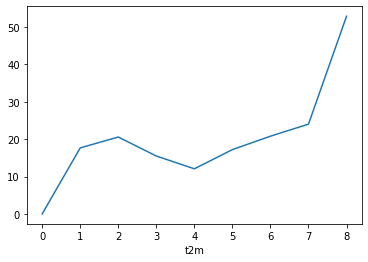

In [208]:
(df1b.groupby('t2m')['timestamp_dt'].nunique()/60).plot()

In [190]:
df1b['dt_1m'] = df1b['timestamp_dt'].dt.ceil('T')

<AxesSubplot:xlabel='dt_1m'>

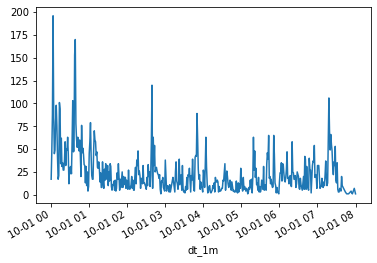

In [188]:
df1b.groupby('dt_1m')['timestamp_dt'].nunique().plot()